# Converts the JHU Cumulative Case Count Data to Daily Case Count Data

# TO DO:
- [ ] Calculate the daily case per 100k population
- [ ] Calculate the daily death per 100k population
- [ ] Merge in population density data
- [ ] Create a data set that will be used for the time to event study. Day 1 for all countries will be the date of their 1st reported case.
- [ ] Research random effects models in time to event studies 
- [ ] Create the data set that will have the cumulative incidence, maximum social distancing **BUT READ** [**THIS ARTICLE**](https://doi.org/10.1101/2020.07.04.20145334) first. It might give you ideas for how to calculate the control measures vars.




## Completed
- [X] There seems to be a problem with the rolling mean calculations. It seems like they are calculated backwards. Probably an issue with the sort before they were created. Make sure they are sorted by country, date
- [X] Figure out how to fix the control measure obs that are recorded as '.'
- [X] Need to explore the missingness of the Oxford data. Sort the countries by GDP and examine what the missingness matrix looks like. **If you could run imputation on this data then you would have a major leg up on the other paper working on the similar topic. (on to of the other benefits to your paper)**
- [X] Write the code that merges in the time series data for the diffent control measures
- [X] Write the code merges in the Country Safety Index data
- [X] Continue to update this **[file](https://1drv.ms/x/s!AjWX5HOdYY23kf9x5S7g8LKLGlseVg?e=992nsi)** of data source locations 
- [X] Write the code that lets you convert the US data to long
- [X] Write the code that converts the column names in the Oxford data set to match the column names in the JHU dat
- [X] Write the code that merges the countries to their offical alpha 3 code in the JHU: **[Link to Codes](https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes)**
- [X] **ALTERNATIVE TO ABOVE** use python-Levenshtein [Docs](https://rawgit.com/ztane/python-Levenshtein/master/docs/Levenshtein.html) distance to match similar country names 
> would still need to pair the high probability matches 
- [X] Write the code transposes the combined data with the control measures included

In [2]:
import pandas as pd
import os
import sys
import shutil
import re
import numpy as np

In [3]:
def Correcting_Col_Names(infile_path, dset):
    infile = pd.read_csv(infile_path)
    # og_col_list = infile.columns.to_list()
    df = pd.DataFrame(infile.columns.to_list())
    df['col'] = df[2:].apply(lambda x: pd.to_datetime(x).dt.strftime('X%m/X%d/%Y').str.replace('X0','').str.replace('X',''))
    df['col'][0] = 'country'
    df['col'][1] = 'country_code'
    cols = df.col.to_list()
    control = pd.read_csv(infile_path, names = cols, skiprows={0:1})
    indexNames = control[ control['country_code'].isna()].index
    control.drop(indexNames, inplace=True)
    df = controls_transpose(control, dset)
    return df

In [4]:
def controls_transpose(dset, var):
    import re
    df = dset.T
    df.columns = df.iloc[0]
    df.columns =df.columns.str.lower()
    df.drop(axis=0, index = {'country', 'country_code'},inplace = True)
    df = df.reset_index().rename(columns={'index':'date'})
    df = long_maker(df, var)
    df.loc[df['country'].str.contains('cape verde',flags= re.IGNORECASE), 'country']= 'cabo verde'
    df.loc[df['country'].str.contains('taiwan',flags= re.IGNORECASE), 'country']= 'taiwan'
    return df

In [5]:
def df_merger(df):
    global long_df
    long_df = long_df.merge(df, on=['date', 'country'],how='outer')
    return long_df

In [6]:
def our_world_importer(filename,sheet, year=2017):
    df = pd.read_excel(f'{control_data_path}\\{filename}.xlsx', sheet_name = sheet)
    df = stats_col_renamer(df)
    df = df.loc[df.year == year]
    df.drop(columns=['entity','year'],inplace=True)
    df.dropna(how='any',inplace=True)
    return df

In [7]:
def stats_col_renamer(dframe):
    """
    Tips: This fuction will remove special characters from column headers, replace spaces with columns, 
    and make all heading lower case

    Parameters
    ----------
    dframe : TYPE Pandas dataframe
        DESCRIPTION.

    Returns
    -------
    None.

    """
    
    dframe.columns = dframe.columns.str.lower()
    dframe.columns = dframe.columns.str.replace('\s{2,}',' ',regex=True).str.replace('-',' ').str.replace(' ','_').str.replace('[^A-Za-z0-9_]+','',regex=True)
    return dframe
data_path = r'..\csse_covid_19_data\csse_covid_19_time_series'
out_data_path = r'..\Modified Data Sets'
control_data_path = '..\Control Data'
case_pre = pd.read_csv(f'{data_path}/time_series_covid19_confirmed_global.csv')
death_pre = pd.read_csv(f'{data_path}/time_series_covid19_deaths_global.csv')

## Importing the JHU COVID Case Data

In [8]:
# case_pre_us = pd.read_csv(f'{data_path}/time_series_covid19_confirmed_US.csv')
# death_pre_us = pd.read_csv(f'{data_path}/time_series_covid19_deaths_US.csv')


file_list = os.listdir(out_data_path)
for files in file_list:
    if files.find('.xlsx') >= 0:
        shutil.move(f'{out_data_path}/{files}',f'{out_data_path}/ARCHIVE/{files}')
def DF_Transform(df, outcome):
    global data_path
    global out_data_path
    
    # Data Cleaning
    df.drop(labels={'Lat','Long'},axis=1, inplace = True)
#     df.loc[df['Country/Region'].str.contains('Congo'), 'Country/Region'] ='Congo'
    df.loc[df['Country/Region'].str.contains('Korea, South',flags= re.IGNORECASE), 'Country/Region']= 'South Korea'
    df.loc[df['Country/Region'] == ('US'), 'Country/Region']= 'United States'
    df.loc[df['Country/Region'].str.contains('taiwan',flags= re.IGNORECASE), 'Country/Region']= 'taiwan'
    # Data Manipulation
    df = df.groupby(by='Country/Region').sum().T.apply(lambda x: x-x.shift(1),axis=0)
    df.rename(columns={'Country/Region':'Date'},inplace=True)
    df.columns = df.columns.str.lower()
    df = df.reset_index()
    df.rename(columns={'index':'date'},inplace= True)
    df.date = pd.to_datetime(df.date).dt.date
#     df['var'] = outcome[16:]
    
    filename = f'{out_data_path}/{outcome} (Through {df.date.max()}).xlsx'
    df.to_excel(filename, index=False)
    return df
case = DF_Transform(case_pre, 'Global COVID-19 Case Count')
death = DF_Transform(death_pre, 'Global COVID-19 Death Count')
# case = DF_Transform(case_pre_us, 'US COVID-19 Case Count')
# death = DF_Transform(death_pre_us, 'US COVID-19 Death Count')

In [9]:
def long_maker(dset, var):
    name_list = dset.columns.to_list()[1:]
    long_df = pd.DataFrame(columns = {'date', var, 'country'})
    for name in name_list:
        df = dset.filter(items={name, 'date'})
        df['country'] = name
        df.rename(columns={name:var},inplace = True)
        long_df = pd.concat([long_df, df],axis=0)
    long_df.date = pd.to_datetime(long_df.date)
    return long_df.reset_index(drop=True)

In [10]:
long_case = long_maker(case, 'case_count')
long_death = long_maker(death, 'death_count')

In [11]:
case_lag_d = case.set_index('date')
case_lag1 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-1),axis=0).reset_index()
case_lag2 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-2),axis=0).reset_index()
case_lag3 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-3),axis=0).reset_index()
case_lag4 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-4),axis=0).reset_index()
case_lag5 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-5),axis=0).reset_index()
case_lag6 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-6),axis=0).reset_index()
case_lag7 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-7),axis=0).reset_index()
case_lag8 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-8),axis=0).reset_index()
case_lag9 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-9),axis=0).reset_index()
case_lag10 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-10),axis=0).reset_index()
case_lag11 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-11),axis=0).reset_index()
case_lag12 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-12),axis=0).reset_index()
case_lag13 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-13),axis=0).reset_index()
case_lag14 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-14),axis=0).reset_index()
case_lag15 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-15),axis=0).reset_index()
case_lag16 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-16),axis=0).reset_index()
case_lag17 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-17),axis=0).reset_index()
case_lag18 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-18),axis=0).reset_index()
case_lag19 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-19),axis=0).reset_index()
case_lag20 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-20),axis=0).reset_index()
case_lag21 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-21),axis=0).reset_index()

death_lag_d = death.set_index('date')
death_lag1 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-1),axis=0).reset_index()
death_lag2 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-2),axis=0).reset_index()
death_lag3 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-3),axis=0).reset_index()
death_lag4 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-4),axis=0).reset_index()
death_lag5 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-5),axis=0).reset_index()
death_lag6 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-6),axis=0).reset_index()
death_lag7 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-7),axis=0).reset_index()
death_lag8 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-8),axis=0).reset_index()
death_lag9 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-9),axis=0).reset_index()
death_lag10 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-10),axis=0).reset_index()
death_lag11 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-11),axis=0).reset_index()
death_lag12 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-12),axis=0).reset_index()
death_lag13 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-13),axis=0).reset_index()
death_lag14 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-14),axis=0).reset_index()
death_lag15 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-15),axis=0).reset_index()
death_lag16 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-16),axis=0).reset_index()
death_lag17 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-17),axis=0).reset_index()
death_lag18 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-18),axis=0).reset_index()
death_lag19 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-19),axis=0).reset_index()
death_lag20 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-20),axis=0).reset_index()
death_lag21 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-21),axis=0).reset_index()

In [12]:
long_1 = long_maker(case_lag1,'case1')
long_2 = long_maker(case_lag2,'case2')
long_3 = long_maker(case_lag3,'case3')
long_4 = long_maker(case_lag4,'case4')
long_5 = long_maker(case_lag5,'case5')
long_6 = long_maker(case_lag6,'case6')
long_7 = long_maker(case_lag7,'case7')
long_8 = long_maker(case_lag8,'case8')
long_9 = long_maker(case_lag9,'case9')
long_10 = long_maker(case_lag10,'case10')
long_11 = long_maker(case_lag11,'case11')
long_12 = long_maker(case_lag12,'case12')
long_13 = long_maker(case_lag13,'case13')
long_14 = long_maker(case_lag14,'case14')
long_15 = long_maker(case_lag15,'case15')
long_16 = long_maker(case_lag16,'case16')
long_17 = long_maker(case_lag17,'case17')
long_18 = long_maker(case_lag18,'case18')
long_19 = long_maker(case_lag19,'case19')
long_20 = long_maker(case_lag20,'case20')
long_21 = long_maker(case_lag21,'case21')   

In [13]:
death_long_1 = long_maker(death_lag1,'death1')
death_long_2 = long_maker(death_lag2,'death2')
death_long_3 = long_maker(death_lag3,'death3')
death_long_4 = long_maker(death_lag4,'death4')
death_long_5 = long_maker(death_lag5,'death5')
death_long_6 = long_maker(death_lag6,'death6')
death_long_7 = long_maker(death_lag7,'death7')
death_long_8 = long_maker(death_lag8,'death8')
death_long_9 = long_maker(death_lag9,'death9')
death_long_10 = long_maker(death_lag10,'death10')
death_long_11 = long_maker(death_lag11,'death11')
death_long_12 = long_maker(death_lag12,'death12')
death_long_13 = long_maker(death_lag13,'death13')
death_long_14 = long_maker(death_lag14,'death14')
death_long_15 = long_maker(death_lag15,'death15')
death_long_16 = long_maker(death_lag16,'death16')
death_long_17 = long_maker(death_lag17,'death17')
death_long_18 = long_maker(death_lag18,'death18')
death_long_19 = long_maker(death_lag19,'death19')
death_long_20 = long_maker(death_lag20,'death20')
death_long_21 = long_maker(death_lag21,'death21')

In [14]:
df_long_list = [case_lag1,case_lag2,case_lag3,case_lag4,case_lag5,case_lag6,
                case_lag7,case_lag8,case_lag9,case_lag10,case_lag11,case_lag12,
                case_lag13,case_lag14,case_lag15,case_lag16,case_lag17,case_lag18,
                case_lag19,case_lag20,case_lag21,death_lag1,death_lag2,death_lag3,
                death_lag4,death_lag5,death_lag6,death_lag7,death_lag8,death_lag9,
                death_lag10,death_lag11,death_lag12,death_lag13,death_lag14,
                death_lag15,death_lag16,death_lag17,death_lag18,death_lag19,death_lag20,
                death_lag21,death_long_1,death_long_2,death_long_3,death_long_4,death_long_5,
               death_long_6,death_long_7,death_long_8,death_long_9,death_long_10,death_long_11,
                death_long_12,death_long_13,death_long_14,death_long_15,death_long_16,death_long_17,
                death_long_18,death_long_19,death_long_20,death_long_21,long_1,long_2,long_3,long_4,
                long_5,long_6,long_7,long_8,long_9,long_10,long_11,long_12,long_13,long_14,
                long_15,long_16,long_17,long_18,long_19,long_20,long_21]

## Importing the Oxford Control Variables

In [15]:
c_measures_path = r'../../../covid-policy-tracker/data'
school = Correcting_Col_Names(f'{c_measures_path}/timeseries/c1_schoolclosing.csv', 'school_close')
work = Correcting_Col_Names(f'{c_measures_path}/timeseries/c2_workplaceclosing.csv', 'work_close')
pub_events = Correcting_Col_Names(f'{c_measures_path}/timeseries/c3_cancelpublicevents.csv', 'public_events')
gatherings = Correcting_Col_Names(f'{c_measures_path}/timeseries/c4_restrictionsongatherings.csv', 'large_gather')
pub_transpo = Correcting_Col_Names(f'{c_measures_path}/timeseries/c5_closepublictransport.csv', 'public_transpo')
stay_home = Correcting_Col_Names(f'{c_measures_path}/timeseries/c6_stayathomerequirements.csv' ,'stay_home')
domestic_travel = Correcting_Col_Names(f'{c_measures_path}/timeseries/c7_domestictravel.csv' ,'domestic_travel')
int_travel = Correcting_Col_Names(f'{c_measures_path}/timeseries/c8_internationaltravel.csv' ,'internat_travel')

In [16]:
#Old merge statment
long_df = long_case.merge(long_death, on=['date', 'country'])
long_df = df_merger(school)
long_df = df_merger(work)
long_df = df_merger(pub_events)
long_df = df_merger(gatherings)
long_df = df_merger(pub_transpo)
long_df = df_merger(stay_home)
long_df = df_merger(domestic_travel)
long_df = df_merger(int_travel)
#Merging Long Case DFs
long_df = df_merger(long_1)
long_df = df_merger(long_2)
long_df = df_merger(long_3)
long_df = df_merger(long_4)
long_df = df_merger(long_5)
long_df = df_merger(long_6)
long_df = df_merger(long_7)
long_df = df_merger(long_8)
long_df = df_merger(long_9)
long_df = df_merger(long_10)
long_df = df_merger(long_11)
long_df = df_merger(long_12)
long_df = df_merger(long_13)
long_df = df_merger(long_14)
long_df = df_merger(long_15)
long_df = df_merger(long_16)
long_df = df_merger(long_17)
long_df = df_merger(long_18)
long_df = df_merger(long_19)
long_df = df_merger(long_20)
long_df = df_merger(long_21)
#Merging the long death vars
long_df = df_merger(death_long_1)
long_df = df_merger(death_long_2)
long_df = df_merger(death_long_3)
long_df = df_merger(death_long_4)
long_df = df_merger(death_long_5)
long_df = df_merger(death_long_6)
long_df = df_merger(death_long_7)
long_df = df_merger(death_long_8)
long_df = df_merger(death_long_9)
long_df = df_merger(death_long_10)
long_df = df_merger(death_long_11)
long_df = df_merger(death_long_12)
long_df = df_merger(death_long_13)
long_df = df_merger(death_long_14)
long_df = df_merger(death_long_15)
long_df = df_merger(death_long_16)
long_df = df_merger(death_long_17)
long_df = df_merger(death_long_18)
long_df = df_merger(death_long_19)
long_df = df_merger(death_long_20)
long_df = df_merger(death_long_21)

In [17]:
school.date.max()

Timestamp('2020-11-03 00:00:00')

In [18]:
# long_df = long_case.merge(long_death, on=['date', 'country'])
# long_df = long_df.merge(school, on=['date', 'country'],how='outer')
# long_df = long_df.merge(work, on=['date', 'country'],how='outer')
# long_df = long_df.merge(pub_events, on=['date', 'country'],how='outer')
# long_df = long_df.merge(gatherings, on=['date', 'country'],how='outer')
# long_df = long_df.merge(pub_transpo, on=['date', 'country'],how='outer')
# long_df = long_df.merge(stay_home, on=['date', 'country'],how='outer')
# long_df = long_df.merge(domestic_travel, on=['date', 'country'],how='outer')
# long_df = long_df.merge(int_travel, on=['date', 'country'],how='outer')
long_df[['school_close',
       'work_close', 'public_events', 'large_gather', 'public_transpo',
       'stay_home', 'domestic_travel', 'internat_travel']] = long_df[['school_close',
       'work_close', 'public_events', 'large_gather', 'public_transpo',
       'stay_home', 'domestic_travel', 'internat_travel']].apply(lambda x: x.str.replace('.','999'))
long_df[['school_close',
       'work_close', 'public_events', 'large_gather', 'public_transpo',
       'stay_home', 'domestic_travel', 'internat_travel']] = long_df[['school_close',
       'work_close', 'public_events', 'large_gather', 'public_transpo',
       'stay_home', 'domestic_travel', 'internat_travel']].fillna(999)
long_df[['school_close',
       'work_close', 'public_events', 'large_gather', 'public_transpo',
       'stay_home', 'domestic_travel', 'internat_travel']] = long_df[['school_close',
       'work_close', 'public_events', 'large_gather', 'public_transpo',
       'stay_home', 'domestic_travel', 'internat_travel']].astype(int)

In [19]:
case_summary = long_df.groupby('country').case_count.agg(['mean','median','std', 'max'])
death_summary = long_df.groupby('country').case_count.agg(['mean','median','std', 'max'])

# Importing Control Variables

In [20]:
control_var_path = '../Control Data'

In [21]:
def country_name_clean(df):
    import re
#     df.loc[(df['country'].str.contains('Congo',re.IGNORECASE)) & (~df['country'].str.contains('dem',re.IGNORECASE)) , 'country'] ='congo'
    df.loc[(df['country'].str.contains('korea, s',flags= re.IGNORECASE)) & (df['country'].str.contains('south',flags= re.IGNORECASE)), 'country']= 'south korea'
    df.loc[df['country'].str.contains('rep')& (df['country'].str.contains('congo',flags= re.IGNORECASE)) ,'country']= 'democratic republic of congo'
    df.loc[df['country'] == ('US'), 'country']= 'united states'
    df.loc[df['country'].str.contains('ivoire|ivory coast',flags= re.IGNORECASE), 'country']= 'cote d\'ivoire'
    df.loc[df['country'].str.contains('venezuela',flags= re.IGNORECASE), 'country']= 'venezuela'
    df.loc[df['country'].str.contains('and principe',flags= re.IGNORECASE), 'country']= 'sao tome and principe'
    df.loc[df['country'].str.contains('and the grenadines',flags= re.IGNORECASE), 'country']= 'saint vincent and the grenadines'
    df.loc[df['country'].str.contains('kitts and nevis',flags= re.IGNORECASE), 'country']= 'saint kitts and nevis'
    df.loc[df['country'].str.contains('bahamas',flags= re.IGNORECASE), 'country']= 'bahamas'
    df.loc[df['country'].str.contains('yemen',flags= re.IGNORECASE), 'country']= 'yemen'
    df.loc[df['country'].str.contains('gambia',flags= re.IGNORECASE), 'country']= 'gambia'
    df.loc[df['country'].str.contains('hong kong',flags= re.IGNORECASE), 'country']= 'hong kong'
    df.loc[df['country'].str.contains('macao',flags= re.IGNORECASE), 'country']= 'macao'
    df.loc[df['country'].str.contains('iran',flags= re.IGNORECASE), 'country']= 'iran'
    df.loc[df['country'].str.contains('lucia',flags= re.IGNORECASE), 'country']= 'saint lucia'
    df.loc[df['country'].str.contains('lao pdr',flags= re.IGNORECASE), 'country']= 'laos'
    df.loc[df['country'].str.contains('egypt',flags= re.IGNORECASE), 'country']= 'egypt'
    df.loc[df['country'].str.contains('korea, rep.',flags= re.IGNORECASE), 'country']= 'south korea'
    df.loc[df['country'].str.contains('states of america',flags= re.IGNORECASE), 'country']= 'united states'
    df.loc[df['country'].str.contains('east timor',flags= re.IGNORECASE), 'country']= 'timor-leste'
    df.loc[df['country'].str.contains('russia',flags= re.IGNORECASE), 'country']= 'russia'
    df.loc[df['country'].str.contains('brunei',flags= re.IGNORECASE), 'country']= 'brunei'
    df.loc[df['country'].str.contains('korea, dem. people\'s rep',flags= re.IGNORECASE), 'country']= 'north korea'
    dset = df.copy()
    return dset


In [22]:
#COVID Regional Safety Assessment Data
safety = pd.read_excel(f'{control_var_path}/COVID-19_Regional_Safety_Assessment.xlsx')
safety.columns = safety.columns.str.lower()
safety.rename(columns={'country/ region':'country'}, inplace=True)
safety.country = safety.country.str.lower()
safety = country_name_clean(safety)

#World Bank GDP Data
gdp = pd.read_excel(f'{control_var_path}/Global GDP.xlsx')
gdp.drop(columns='Unnamed: 4', inplace=True)
gdp.columns = gdp.columns.str.lower()
gdp.rename(columns={'economy':'country'}, inplace=True)
gdp.country = gdp.country.str.lower()

og_data = pd.read_excel('..\..\Country Response Paper\Original Documents\Country Responses-selected\Country Responses Dataset 7.28.20.xlsx',sheet_name = 'Country Responses')
og_data.index = og_data['Country/Region']
og_data = og_data.iloc[0:,19:]
og_data = og_data.reset_index(drop=False).rename(columns={'Country/Region':'country'})
og_data.columns = og_data.columns.str.lower()
og_data = stats_col_renamer(og_data)
og_data.dropna(how='all',inplace=True)
og_data.country = og_data.country.str.lower()

safety = country_name_clean(safety)
gdp = country_name_clean(gdp)
og_data = country_name_clean(og_data)

In [23]:
og_data.columns

Index(['country', 'population', 'ages_65_and_above__of_total_population',
       'female__of_total', 'diabetes_prevalence__of_population_ages_20_to_79',
       'obese__of_adult_population', 'htn_prevalence',
       'smoking_prevalence_ages_15', 'cancer_prevalence_',
       'hiv_prevalence__of_population_ages_15_49', 'copd_dalys_per_100000',
       'sars_experience_0_no_1_yes'],
      dtype='object')

# Importing and evaluating the smoking dataset from Our World Data

In [25]:
#Smoking Data
smk_die_rate = our_world_importer('share-deaths-smoking', 'death-rate-smoking')
smk_die_prop = our_world_importer('share-deaths-smoking', 'share-deaths-smoking')
#HIV Data
hiv_prev = our_world_importer('hiv-data','share-of-population-infected-wi')
hiv_death = our_world_importer('hiv-data','hiv-death-rates')
#Obesity Data
obese = our_world_importer('share-of-deaths-obesity','share-of-deaths-obesity')
#Population Data
pop = our_world_importer('projected-population-by-country', 'projected-population-by-country',year=2020)
pop_den.rename(columns={'population_density_people_per_sq_km_of_land_area':'pop_den_per_sqkm'},inplace=True)
pop_den = our_world_importer('population-density','population-density', year=2017)
#Age Data
age = our_world_importer('median-age','median-age',year=2020)
#Diabetes Data
diabet = our_world_importer('diabetes-prevalence', 'diabetes-prevalence')
mers = pd.read_excel(f'{control_data_path}\MERS-SARS.xlsx',sheet_name='MERS')
sars = pd.read_excel(f'{control_data_path}\MERS-SARS.xlsx',sheet_name='SARS')
mers = stats_col_renamer(mers)
sars = stats_col_renamer(sars)
sars.drop(columns=['number_of_hcw_affected_', 'date_onset_first_probable_case',
       'date_onset_last_probable_case','case_fatality_ratio_','female', 'male','areas','median_age_range'],inplace=True)
mers.drop(columns='country',inplace=True)

### How to Merge a lot of DataFrames
> Method 1

In [30]:
from functools import partial, reduce

In [31]:
dfs = [smk_die_rate, smk_die_prop,hiv_prev, hiv_death, obese, pop, pop_den, age, diabet, mers, sars]
merge = partial(pd.merge,on='code', how='outer')
control = reduce(merge,dfs)
control[['mers_case_count',
       'sars_case_count', 'number_of_deathsa', 'number_of_imported_cases',
       'percent_of_imported_cases']] = control[['mers_case_count',
       'sars_case_count', 'number_of_deathsa', 'number_of_imported_cases',
       'percent_of_imported_cases']].fillna(0)
control['mers_sars_max'] = control[['mers_case_count', 'sars_case_count']].max(axis=1)
control['mers_sars_sum'] = control[['mers_case_count', 'sars_case_count']].sum(axis=1)
mers_sars_sum =  control.loc[control.mers_sars_sum > 0 ]['mers_sars_sum']
des_mers_sum = mers_sars_sum.describe().to_frame()
q1 = int(des_mers_sum.iloc[4].values)
q2 = int(des_mers_sum.iloc[5].values)
q3 = int(des_mers_sum.iloc[6].values)
#creating the quartile variable
control['mers_sars_quart'] = 0
control.loc[(control.mers_sars_sum > 0) & (control.mers_sars_sum <= q1), 'mers_sars_quart']=1
control.loc[(control.mers_sars_sum > q1) & (control.mers_sars_sum <= q2), 'mers_sars_quart']=2
control.loc[(control.mers_sars_sum > q2) & (control.mers_sars_sum <= q3), 'mers_sars_quart']=3
control.loc[control.mers_sars_sum > q3, 'mers_sars_quart']=4

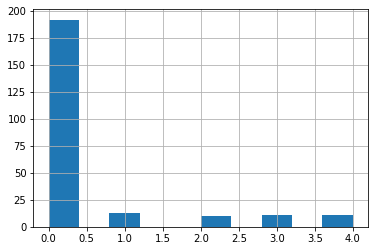

In [26]:
control.mers_sars_quart.hist()

In [27]:
control.mers_sars_sum.sum()

10545.0

In [28]:
mers_sars_sum

2         2.0
9         6.0
10        2.0
13        1.0
32      251.0
37     5328.0
53        1.0
61        9.0
65       12.0
67        1.0
79        3.0
80        2.0
81        6.0
83        1.0
85        5.0
88       28.0
92        5.0
96        2.0
105       7.0
115       9.0
122       2.0
123       1.0
130      24.0
137      16.0
141      19.0
142       1.0
143       1.0
149    2058.0
154     238.0
159       1.0
160     189.0
162       1.0
167       5.0
168       1.0
170     346.0
173      12.0
178       3.0
179       1.0
183      87.0
184       9.0
185      29.0
191      63.0
193       1.0
210    1755.0
213       1.0
Name: mers_sars_sum, dtype: float64

In [32]:
control.mers_sars_sum.describe()

count     238.000000
mean       44.306723
std       387.167441
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      5328.000000
Name: mers_sars_sum, dtype: float64

> Method 2

In [33]:
# control = smk_die_rate.copy()
# control = control.merge(smk_die_prop, on='code', how='outer')
# control = control.merge(hiv_prev, on='code', how='outer')
# control = control.merge(hiv_death, on='code', how='outer')
# control = control.merge(obese, on='code', how='outer')
# control = control.merge(pop, on='code', how='outer')
# control = control.merge(age, on='code', how='outer')
# control = control.merge(diabet, on='code', how='outer')
# control = control.merge(mers, on='code', how='outer')
# control = control.merge(sars, on='code', how='outer')

# Final Merges

In [168]:
long_df_newcontrol = control.merge(gdp,left_on='code',right_on='countrycode',how='outer')
long_df_newcontrol = long_df_newcontrol.merge(long_df, on=['country'],how='outer')
long_df_newcontrol = long_df_newcontrol.merge(safety, on=['country'],how='outer')
long_df_newcontrol = long_df_newcontrol.merge(og_data, on=['country'],how='outer')
long_df_newcontrol.rename(columns={'us_dollars_in_mil':'gdp_in_mil_us', 'ranking':'gdp_rank'},inplace=True)
long_df_newcontrol = stats_col_renamer(long_df_newcontrol)
long_df_newcontrol.drop(columns={'global_region','code'},inplace=True)
long_df_newcontrol.columns = long_df_newcontrol.columns.str.replace('__','_')
long_df_newcontrol.countrycode = long_df_newcontrol.countrycode.str.upper()
long_df_order = ['date',  'country','case_count', 'death_count', 'school_close',
       'work_close', 'public_events', 'large_gather', 'public_transpo',
       'stay_home', 'domestic_travel', 'internat_travel', 'population','pop_den_per_sqkm',
       'ages_65_and_above_of_total_population', 'female_of_total',
       'diabetes_prevalence_of_population_ages_20_to_79',
       'obese_of_adult_population', 'htn_prevalence',
       'smoking_prevalence_ages_15', 'cancer_prevalence_',
       'hiv_prevalence_of_population_ages_1549', 'copd_dalys_per_100000',
       'sars_experience_0_no_1_yes', 'quarantine_efficiency', 'gov_efficiency',
       'monitoring_and_detection', 'healthcare_readiness',
       'country_vulnerability', 'emergency_preparedness', 'total_score',
       'countrycode', 'gdp_rank', 'gdp_in_mil_us']
long_df_newcontrol = long_df_newcontrol.filter(items=['country','countrycode','date','case_count','death_count',
'school_close', 'domestic_travel','internat_travel','large_gather', 'public_events',
'stay_home', 'work_close' 'public_transpo',
'gdp_rank', 'us_dollars_in_mil','smoking_ihme_2019', 'population_by_country_and_region_historic_and_projections_gapminder_hyde_un','pop_den_per_sqkm',
'un_population_division_median_age_2017','ages_65_and_above_of_total_population',
'prevalence_hivaids_sex_both_age_15_49_years_percent',
'deaths_hivaids_sex_both_age_age_standardized_rate', 
'diabetes_prevalence_of_population_ages_20_to_79_x',
'deaths_smoking_sex_both_age_age_standardized_rate','cancer_prevalence_',
'htn_prevalence', 'copd_dalys_per_100000', 'obesity_ihme_2019',
'country_vulnerability','emergency_preparedness','gov_efficiency','healthcare readiness',
'monitoring and detection', 'quarantine_efficiency', 'total_score',
'mers_case_count', 'sars_case_count', 'mers_sars_sum','mers_sars_quart','mers_sars_max' , 
'number_of_deathsa', 'number_of_imported_cases', 'percent_of_imported_cases',
'case1', 'case2', 'case3', 'case4', 'case5', 'case6', 'case7', 'case8',
'case9', 'case10', 'case11', 'case12', 'case13', 'case14', 'case15',
'case16', 'case17', 'case18', 'case19', 'case20', 'case21', 'death1',
'death2', 'death3', 'death4', 'death5', 'death6', 'death7', 'death8',
'death9', 'death10', 'death11', 'death12', 'death13', 'death14',
'death15', 'death16', 'death17', 'death18', 'death19', 'death20',
'death21'])
long_df_newcontrol.rename(columns={'us_dollars_in_mil':'gdp_in_mil_us', 'population_by_country_and_region_historic_and_projections_gapminder_hyde_un':'pop_2020',
                                   'deaths_hivaids_sex_both_age_age_standardized_rate':'deaths_hivaids_sex_both_age',
                                  'diabetes_prevalence_of_population_ages_20_to_79_x':'diabetes_prev_ages_20_to_79',
                                  'cancer_prevalence_':'cancer_prevalence'},inplace=True)
date = long_df_newcontrol.date.max().date()
date

datetime.date(2020, 11, 3)

Creating SARS/MERS Experience Variables

In [169]:
long_df_newcontrol.mers_case_count = long_df_newcontrol.mers_case_count.fillna(0)
long_df_newcontrol.sars_case_count = long_df_newcontrol.sars_case_count.fillna(0)
long_df_newcontrol['mers_sars_exp1'] = 0
long_df_newcontrol['mers_sars_exp5'] = 0
long_df_newcontrol['mers_sars_exp10'] = 0
long_df_newcontrol['mers_sars_exp20'] = 0
long_df_newcontrol['mers_sars_exp100'] = 0
long_df_newcontrol['mers_sars_exp200'] = 0
long_df_newcontrol.loc[long_df_newcontrol.mers_sars_max >= 1, 'mers_sars_exp1' ] = 1
long_df_newcontrol.loc[long_df_newcontrol.mers_sars_max >= 5, 'mers_sars_exp5' ] = 1
long_df_newcontrol.loc[long_df_newcontrol.mers_sars_max >= 10, 'mers_sars_exp10' ] = 1
long_df_newcontrol.loc[long_df_newcontrol.mers_sars_max >= 20, 'mers_sars_exp20' ] = 1
long_df_newcontrol.loc[long_df_newcontrol.mers_sars_max >= 100, 'mers_sars_exp100' ] = 1
long_df_newcontrol.loc[long_df_newcontrol.mers_sars_max >= 200, 'mers_sars_exp200' ] = 1
long_df_newcontrol['log_case_count']=0
long_df_newcontrol['log_death_count']=0
long_df_newcontrol.loc[long_df_newcontrol.case_count == 0, 'log_case_count' ] = np.log(long_df_newcontrol.case_count + .5)
long_df_newcontrol.loc[long_df_newcontrol.case_count > 0, 'log_case_count' ] = np.log(long_df_newcontrol.case_count)
long_df_newcontrol.loc[long_df_newcontrol.death_count == 0, 'log_death_count' ] = np.log(long_df_newcontrol.death_count + .5)
long_df_newcontrol.loc[long_df_newcontrol.death_count > 0, 'log_death_count' ] = np.log(long_df_newcontrol.death_count)
long_df_newcontrol = long_df_newcontrol.loc[~long_df_newcontrol.date.isnull()]
long_df_newcontrol = long_df_newcontrol.sort_values(by=['country','date'])
multii = long_df_newcontrol.set_index(['country','date'])
# rolmean_case =  pd.DataFrame(multii.groupby(['country','date'])['case_count'].rolling(7).mean())
rolmean_case =  pd.DataFrame(multii.groupby(level=0,as_index=False,group_keys=False)['case_count'].rolling(7).mean()).reset_index(level=0, drop=True)
rolmean_death =  pd.DataFrame(multii.groupby(as_index=False,level=0)['death_count'].rolling(30).mean()).reset_index(level=0, drop=True)
rolmeans = rolmean_case.merge(rolmean_death,left_index=True,right_index=True)
rolmeans.rename(columns={'case_count':'case_rol_mean7','death_count':'death_rol_mean7'},inplace=True)
rolmeans.reset_index(inplace=True)
finaldf = long_df_newcontrol.merge(rolmeans, on=['country','date'])

E:\Anaconda\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
E:\Anaconda\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
E:\Anaconda\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
E:\Anaconda\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
E:\Anaconda\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
E:\Anaconda\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [170]:
rolmeans

,country,date,case_rol_mean7,death_rol_mean7
0,afghanistan,2020-01-01,NaN,NaN
1,afghanistan,2020-01-02,NaN,NaN
2,afghanistan,2020-01-03,NaN,NaN
3,afghanistan,2020-01-04,NaN,NaN
4,afghanistan,2020-01-05,NaN,NaN
...,...,...,...,...
69351,zimbabwe,2020-10-30,NaN,NaN
69352,zimbabwe,2020-10-31,NaN,NaN
69353,zimbabwe,2020-11-01,NaN,NaN
69354,zimbabwe,2020-11-02,NaN,NaN


In [154]:
rolmean_case

case_count
country     date                  
afghanistan 2020-01-01         NaN
            2020-01-02         NaN
            2020-01-03         NaN
            2020-01-04         NaN
            2020-01-05         NaN
...                            ...
zimbabwe    2020-10-30         NaN
            2020-10-31         NaN
            2020-11-01         NaN
            2020-11-02         NaN
            2020-11-03         NaN

[65660 rows x 1 columns]

In [47]:
finaldf.set_index('date').groupby('country').case_rol_mean7.plot()

NameError: name 'finaldf' is not defined

In [ ]:
finaldf.columns

In [46]:
finaldf.to_excel(f'{out_data_path}\\Final COVID Data Set (Through {date}) (ver2).xlsx',index=False)

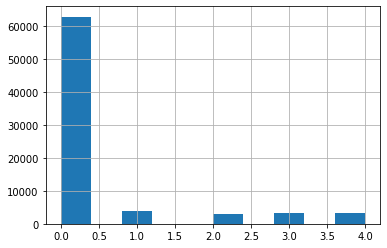

In [47]:
finaldf.mers_sars_quart.hist()

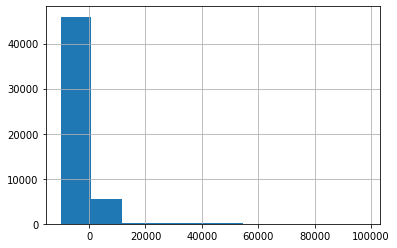

In [48]:
long_df_newcontrol.case_count.hist()

# Checking to see How often case count values are greater than 10

In [ ]:
test = pd.DataFrame()

In [ ]:
test[['country','date','case','death']] = long_df_newcontrol[['country','date','case_count','death_count']]

In [ ]:
test['g10'] = 0

In [ ]:
test.loc[test.case >=10 ,'g10']=1

In [ ]:
test.g10.value_counts()/test.shape[0]

## trying to work out country linking stuff

In [ ]:
def similar_check(q,l):
    from fuzzywuzzy import fuzz,process
    from Levenshtein import distance,ratio
    import pandas as pd
    jhu = []
    similar = []
    query = []
    for countries in q:
        results = process.extractOne(countries,list(jhu_country)) 
        if results[1] < 100:
            jhu.append(results[0])
            similar.append(results[1])
            query.append(countries)
    output = pd.DataFrame({'query_country':query, 
                          'similarity':similar,
                           'jhu_country':jhu                       
                          })
    return output

In [ ]:
# a list of the country names from each data set
jhu_country = long_case.country.unique()
ox_country = school.country.unique()
gdp_country = gdp.country
safe_country = safety.country
og_country = og_data.country

### Country Name Cleaner

## Oxford Data Country Names

In [ ]:
ox_check = similar_check(ox_country ,jhu_country)
ox_check.sort_values(by='similarity', ascending=False)

## GDP Data Country Names

In [ ]:
gdp_check = similar_check(gdp_country ,jhu_country)
gdp_check.sort_values(by='similarity', ascending=False)

## Safety Data Country Names

In [ ]:
safe_check = similar_check(safe_country ,jhu_country)
safe_check.sort_values(by='similarity', ascending=False).head(50)

## OG Data Country Names

In [ ]:
og_check = similar_check(og_country ,jhu_country)
og_check.sort_values(by='similarity', ascending=False)

# Code Grave Yard

### Importing the Oxford Control Measures Data Set (Ordinal)

In [ ]:

# from fuzzywuzzy import fuzz,process
# from Levenshtein import distance,ratio
# import pandas as pd
# jhu = []
# similar = []
# ox = []
# for countries in ox_country:
#     results = process.extractOne(countries,list(jhu_country)) 
#     if results[1] < 100:
#         jhu.append(results[0])
#         similar.append(results[1])
#         ox.append(countries)
# output = pd.DataFrame({'oxford_country':ox, 
#                       'similarity':similar,
#                        'jhu_country':jhu                       
#                       })